#### Setup:

In [ ]:
!pip install -U tensorflow keras

In [ ]:
!pip install -U talos

In [ ]:
# Import general Python libraries
import pandas as pd
import numpy as np
import scipy
import random
import sklearn
import seaborn as sns
import os
import matplotlib.pyplot as plt
import itertools

In [ ]:
# Specify seeds for random-operations
seed_value = 0
os.environ['PYTHONHASHSEED']=str(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)

In [ ]:
# Import sklearn-specific modules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.base import BaseEstimator, TransformerMixin

In [ ]:
# Import tensorflow-specific modules
import tensorflow as tf
tf.random.set_seed(seed_value)
print("Tensorflow Version: {}".format(tf.__version__))
print("Keras Version: {}".format(tf.keras.__version__))

Tensorflow Version: 2.4.1
Keras Version: 2.4.0


In [ ]:
# Import keras-specific modules
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Input, Average, Concatenate
from tensorflow.keras.optimizers import Adadelta, RMSprop, Adam, Adamax, Nadam
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.initializers import GlorotNormal, GlorotUniform, HeNormal, HeUniform, LecunNormal, LecunUniform
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.utils import plot_model

In [ ]:
# Import talos-specific modules
import talos

In [ ]:
# Set pandas options
pd.set_option("display.max_columns", None)

In [ ]:
# Adjust stopword list
stopwords = list(ENGLISH_STOP_WORDS) + ["kickstarter", "year", "dollar"]
len(stopwords)

321

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Prepare Dataset:

In [ ]:
# Import Dataset
kickstarter_df = pd.read_csv("04_Final Datasets/Kickstarter_Structured_and_Text.csv", index_col=0)
print(kickstarter_df.shape)
print(len(kickstarter_df.index.unique()))
kickstarter_df.head(1)

(246891, 41)
246891


,campaign_successful,title,blurb,story,risks,reward_description,creator_bio,goal,number_of_collaborators,funding_period,days_between_created_and_launched,launch_quartal,staff_pick,campaign_has_demo_video,campaign_has_environmental_commitments,number_of_images,number_of_videos,number_of_audios,number_of_interactives,number_of_words,number_of_links,creator_verified_identity,creator_fb_auth,creator_has_image,creator_allows_follows,number_of_creator_backings,number_of_creator_projects,facebook_linked,twitter_linked,instagram_linked,linkedin_linked,number_of_rewards,number_of_words_per_reward,lowest_pledge_level,highest_pledge_level,has_limited_rewards,has_shipped_rewards,has_restricted_shipping_rewards,avg_months_until_reward,location,category
22821161,0,sentio golf putters. feel is the difference,choose the feel you want with our patented flo...,sentio putters feature a unique floating face...,high tech process although we have made severa...,our eternal gratitude. every little bit helps ...,sentio golf is driven to produce the most adva...,50000.0,0,45,102,3,0,1,0,13,0,0,0,1378,2,1,0,1,1,0,1,0,0,0,0,8,36.75,5.0,1417.0,0,1,1,5.5,United States,Design_Product Design


In [ ]:
# Convert categorical features into dummy-variables
print("Before: {}".format(kickstarter_df.shape))
kickstarter_df["launch_quartal"] = kickstarter_df.launch_quartal.apply(str)
kickstarter_df = pd.get_dummies(kickstarter_df, prefix=["launch_quartal", "location", "category"], columns=["launch_quartal", "location", "category"], drop_first=False)
print("After: {}".format(kickstarter_df.shape))
kickstarter_df.head(1)

Before: (246891, 41)
After: (246891, 240)


,campaign_successful,title,blurb,story,risks,reward_description,creator_bio,goal,number_of_collaborators,funding_period,days_between_created_and_launched,staff_pick,campaign_has_demo_video,campaign_has_environmental_commitments,number_of_images,number_of_videos,number_of_audios,number_of_interactives,number_of_words,number_of_links,creator_verified_identity,creator_fb_auth,creator_has_image,creator_allows_follows,number_of_creator_backings,number_of_creator_projects,facebook_linked,twitter_linked,instagram_linked,linkedin_linked,number_of_rewards,number_of_words_per_reward,lowest_pledge_level,highest_pledge_level,has_limited_rewards,has_shipped_rewards,has_restricted_shipping_rewards,avg_months_until_reward,launch_quartal_1,launch_quartal_2,launch_quartal_3,launch_quartal_4,location_Africa,location_Australia,location_Belgium,location_Canada,location_China,location_Denmark,location_France,location_Germany,location_Hong Kong,location_Ireland,location_Italy,location_Japan,location_Latin and South America,location_Mexico,location_Netherlands,location_New Zealand,location_No Location,location_Norway,location_Oceania and Antarctica,location_Rest of Asia,location_Rest of Europe,location_Singapore,location_Spain,location_Sweden,location_Switzerland,location_United Kingdom,location_United States,category_Art_Ceramics,category_Art_Conceptual Art,category_Art_Digital Art,category_Art_Illustration,category_Art_Installations,category_Art_Mixed Media,category_Art_No Subcategory,category_Art_Painting,category_Art_Performance Art,category_Art_Public Art,category_Art_Sculpture,category_Art_Social Practice,category_Art_Textiles,category_Art_Video Art,category_Comics_Anthologies,category_Comics_Comic Books,category_Comics_Events,category_Comics_Graphic Novels,category_Comics_No Subcategory,category_Comics_Webcomics,category_Crafts_Candles,category_Crafts_Crochet,category_Crafts_DIY,category_Crafts_Embroidery,category_Crafts_Glass,category_Crafts_Knitting,category_Crafts_No Subcategory,category_Crafts_Pottery,category_Crafts_Printing,category_Crafts_Quilts,category_Crafts_Stationery,category_Crafts_Taxidermy,category_Crafts_Weaving,category_Crafts_Woodworking,category_Dance_No Subcategory,category_Dance_Performances,category_Dance_Residencies,category_Dance_Spaces,category_Dance_Workshops,category_Design_Architecture,category_Design_Civic Design,category_Design_Graphic Design,category_Design_Interactive Design,category_Design_No Subcategory,category_Design_Product Design,category_Design_Toys,category_Design_Typography,category_Fashion_Accessories,category_Fashion_Apparel,category_Fashion_Childrenswear,category_Fashion_Couture,category_Fashion_Footwear,category_Fashion_Jewelry,category_Fashion_No Subcategory,category_Fashion_Pet Fashion,category_Fashion_Ready-to-wear,category_Film & Video_Action,category_Film & Video_Animation,category_Film & Video_Comedy,category_Film & Video_Documentary,category_Film & Video_Drama,category_Film & Video_Experimental,category_Film & Video_Family,category_Film & Video_Fantasy,category_Film & Video_Festivals,category_Film & Video_Horror,category_Film & Video_Movie Theaters,category_Film & Video_Music Videos,category_Film & Video_Narrative Film,category_Film & Video_No Subcategory,category_Film & Video_Romance,category_Film & Video_Science Fiction,category_Film & Video_Shorts,category_Film & Video_Television,category_Film & Video_Thrillers,category_Film & Video_Webseries,category_Food_Bacon,category_Food_Community Gardens,category_Food_Cookbooks,category_Food_Drinks,category_Food_Events,category_Food_Farmer's Markets,category_Food_Farms,category_Food_Food Trucks,category_Food_No Subcategory,category_Food_Restaurants,category_Food_Small Batch,category_Food_Spaces,category_Food_Vegan,category_Games_Gaming Hardware,category_Games_Live Games,category_Games_Mobile Games,category_Games_No Subcategory,category_Games_Playing Cards,category_Games_Puzzles,category_Games_Tabletop Games,category_Games_Video Games,category_Journa

In [ ]:
# Merge all text-attributes together
kickstarter_df["text"] = kickstarter_df["title"] + " " + kickstarter_df["blurb"] + " " + kickstarter_df["story"] + " " + kickstarter_df["risks"] + " " + kickstarter_df["creator_bio"] + " " + kickstarter_df["reward_description"]
kickstarter_df.drop(columns=["title", "blurb", "story", "risks", "creator_bio", "reward_description"], inplace=True)
print(kickstarter_df.shape)
kickstarter_df.head(1)

(246891, 235)


,campaign_successful,goal,number_of_collaborators,funding_period,days_between_created_and_launched,staff_pick,campaign_has_demo_video,campaign_has_environmental_commitments,number_of_images,number_of_videos,number_of_audios,number_of_interactives,number_of_words,number_of_links,creator_verified_identity,creator_fb_auth,creator_has_image,creator_allows_follows,number_of_creator_backings,number_of_creator_projects,facebook_linked,twitter_linked,instagram_linked,linkedin_linked,number_of_rewards,number_of_words_per_reward,lowest_pledge_level,highest_pledge_level,has_limited_rewards,has_shipped_rewards,has_restricted_shipping_rewards,avg_months_until_reward,launch_quartal_1,launch_quartal_2,launch_quartal_3,launch_quartal_4,location_Africa,location_Australia,location_Belgium,location_Canada,location_China,location_Denmark,location_France,location_Germany,location_Hong Kong,location_Ireland,location_Italy,location_Japan,location_Latin and South America,location_Mexico,location_Netherlands,location_New Zealand,location_No Location,location_Norway,location_Oceania and Antarctica,location_Rest of Asia,location_Rest of Europe,location_Singapore,location_Spain,location_Sweden,location_Switzerland,location_United Kingdom,location_United States,category_Art_Ceramics,category_Art_Conceptual Art,category_Art_Digital Art,category_Art_Illustration,category_Art_Installations,category_Art_Mixed Media,category_Art_No Subcategory,category_Art_Painting,category_Art_Performance Art,category_Art_Public Art,category_Art_Sculpture,category_Art_Social Practice,category_Art_Textiles,category_Art_Video Art,category_Comics_Anthologies,category_Comics_Comic Books,category_Comics_Events,category_Comics_Graphic Novels,category_Comics_No Subcategory,category_Comics_Webcomics,category_Crafts_Candles,category_Crafts_Crochet,category_Crafts_DIY,category_Crafts_Embroidery,category_Crafts_Glass,category_Crafts_Knitting,category_Crafts_No Subcategory,category_Crafts_Pottery,category_Crafts_Printing,category_Crafts_Quilts,category_Crafts_Stationery,category_Crafts_Taxidermy,category_Crafts_Weaving,category_Crafts_Woodworking,category_Dance_No Subcategory,category_Dance_Performances,category_Dance_Residencies,category_Dance_Spaces,category_Dance_Workshops,category_Design_Architecture,category_Design_Civic Design,category_Design_Graphic Design,category_Design_Interactive Design,category_Design_No Subcategory,category_Design_Product Design,category_Design_Toys,category_Design_Typography,category_Fashion_Accessories,category_Fashion_Apparel,category_Fashion_Childrenswear,category_Fashion_Couture,category_Fashion_Footwear,category_Fashion_Jewelry,category_Fashion_No Subcategory,category_Fashion_Pet Fashion,category_Fashion_Ready-to-wear,category_Film & Video_Action,category_Film & Video_Animation,category_Film & Video_Comedy,category_Film & Video_Documentary,category_Film & Video_Drama,category_Film & Video_Experimental,category_Film & Video_Family,category_Film & Video_Fantasy,category_Film & Video_Festivals,category_Film & Video_Horror,category_Film & Video_Movie Theaters,category_Film & Video_Music Videos,category_Film & Video_Narrative Film,category_Film & Video_No Subcategory,category_Film & Video_Romance,category_Film & Video_Science Fiction,category_Film & Video_Shorts,category_Film & Video_Television,category_Film & Video_Thrillers,category_Film & Video_Webseries,category_Food_Bacon,category_Food_Community Gardens,category_Food_Cookbooks,category_Food_Drinks,category_Food_Events,category_Food_Farmer's Markets,category_Food_Farms,category_Food_Food Trucks,category_Food_No Subcategory,category_Food_Restaurants,category_Food_Small Batch,category_Food_Spaces,category_Food_Vegan,category_Games_Gaming Hardware,category_Games_Live Games,category_Games_Mobile Games,category_Games_No Subcategory,category_Games_Playing Cards,category_Games_Puzzles,category_Games_Tabletop Games,category_Games_Video Games,category_Journalism_Audio,category_Journalism_No Subcategory,category_

In [ ]:
# Convert dataset and target variable to Numpy Arrays
y = kickstarter_df["campaign_successful"].to_numpy()
kickstarter_df.drop(columns=["campaign_successful"], inplace=True)
X = kickstarter_df.to_numpy()

print(type(y))
print(y.shape)
print(type(X))
print(X.shape)

<class 'numpy.ndarray'>
(246891,)
<class 'numpy.ndarray'>
(246891, 234)


In [ ]:
# Retrieve column names which will be used for later pre-processing
feature_names = kickstarter_df.columns.values
text_feature_names = "text"
numeric_feature_names = ["goal", "number_of_collaborators", "funding_period", "days_between_created_and_launched", "number_of_images", "number_of_videos", "number_of_audios", "number_of_interactives", "number_of_words", "number_of_links", "number_of_creator_backings", "number_of_creator_projects", "number_of_rewards", "number_of_words_per_reward", "lowest_pledge_level", "highest_pledge_level", "avg_months_until_reward"]
binary_feature_names = [x for x in feature_names if (x not in numeric_feature_names) & (x != text_feature_names)]
text_features = kickstarter_df.columns.get_loc(text_feature_names)
numeric_features = [kickstarter_df.columns.get_loc(x) for x in numeric_feature_names]
binary_features = [kickstarter_df.columns.get_loc(x) for x in binary_feature_names]
print(len(numeric_feature_names)+len(binary_feature_names) + 1)
print(len(numeric_features)+len(binary_features))

233
233


In [ ]:
# Split dataset into training, subtraining, validation, and test set
train_size = round(kickstarter_df.shape[0]*0.7*1)
val_size = round(kickstarter_df.shape[0]*0.15*1)
test_size = round(kickstarter_df.shape[0]*1) - val_size - train_size

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=(train_size+val_size), test_size=test_size, shuffle=True, stratify=y, random_state=seed_value)
X_subtrain, X_val, y_subtrain, y_val = train_test_split(X_train, y_train, train_size=train_size, test_size=val_size, shuffle=True, stratify=y_train, random_state=seed_value)

print("Shape of X_train: {}".format(X_train.shape))
print("Shape of y_train: {}".format(y_train.shape))
print("Shape of X_subtrain: {}".format(X_subtrain.shape))
print("Shape of y_subtrain: {}".format(y_subtrain.shape))
print("Shape of X_val: {}".format(X_val.shape))
print("Shape of y_val: {}".format(y_val.shape))
print("Shape of X_test: {}".format(X_test.shape))
print("Shape of y_test: {}".format(y_test.shape))

Shape of X_train: (209858, 234)
Shape of y_train: (209858,)
Shape of X_subtrain: (172824, 234)
Shape of y_subtrain: (172824,)
Shape of X_val: (37034, 234)
Shape of y_val: (37034,)
Shape of X_test: (37033, 234)
Shape of y_test: (37033,)


In [ ]:
# Create a dummy transformer that simply returns the original column (used for binary features)
class NoTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, np.ndarray)
        return X

In [ ]:
# Perform Dataset Transformation (Subtraining vs. Validation Set)
# Strategy: PowerTransform + Standardize Numerical Features; Leave Binary Features as they are; Tfidf Vectorize Text Features
preprocessing = ColumnTransformer(
    [
      ("numeric", PowerTransformer(method="yeo-johnson", standardize=True), numeric_features),
      ("binary", NoTransformer(), binary_features),
      ("text", TfidfVectorizer(stop_words=stopwords, ngram_range=(1,2), analyzer="word", max_features=75000, sublinear_tf=True, dtype=np.float32), text_features)
    ], remainder="drop", verbose=True).fit(X_subtrain)

X_subtrain = preprocessing.transform(X_subtrain)
X_val = preprocessing.transform(X_val)

[ColumnTransformer] ....... (1 of 3) Processing numeric, total=   6.2s
[ColumnTransformer] ........ (2 of 3) Processing binary, total=   0.0s
[ColumnTransformer] .......... (3 of 3) Processing text, total= 8.4min


In [ ]:
# Perform Dataset Transformation (Training vs. Test Set)
# Strategy: PowerTransform + Standardize Numerical Features; Leave Binary Features as they are; Tfidf Vectorize Text Features
preprocessing2 = ColumnTransformer(
    [
      ("numeric", PowerTransformer(method="yeo-johnson", standardize=True), numeric_features),
      ("binary", NoTransformer(), binary_features),
      ("text", TfidfVectorizer(stop_words=stopwords, ngram_range=(1,2), analyzer="word", max_features=75000, sublinear_tf=True, dtype=np.float32), text_features)
    ], remainder="drop", verbose=True).fit(X_train)

X_train = preprocessing2.transform(X_train)
X_test = preprocessing2.transform(X_test)

[ColumnTransformer] ....... (1 of 3) Processing numeric, total=   7.2s
[ColumnTransformer] ........ (2 of 3) Processing binary, total=   0.0s
[ColumnTransformer] .......... (3 of 3) Processing text, total=10.2min


In [ ]:
# Split structured and text features
X_subtrain_structured = X_subtrain[:,0:233].toarray()
X_val_structured = X_val[:,0:233].toarray()
X_train_structured = X_train[:,0:233].toarray()
X_test_structured = X_test[:,0:233].toarray()

X_subtrain_text = X_subtrain[:,233:]
X_val_text = X_val[:,233:]
X_train_text = X_train[:,233:]
X_test_text = X_test[:,233:]

print("Shape of X_subtrain_structured: {}".format(X_subtrain_structured.shape))
print("Datatype of X_subtrain_structured: {}".format(type(X_subtrain_structured)))
print("Shape of X_val_structured: {}".format(X_val_structured.shape))
print("Datatype of X_val_structured: {}".format(type(X_val_structured)))
print("Shape of X_train_structured: {}".format(X_train_structured.shape))
print("Datatype of X_train_structured: {}".format(type(X_train_structured)))
print("Shape of X_test_structured: {}".format(X_test_structured.shape))
print("Datatype of X_test_structured: {}".format(type(X_test_structured)))

print("Shape of X_subtrain_text: {}".format(X_subtrain_text.shape))
print("Datatype of X_subtrain_text: {}".format(type(X_subtrain_text)))
print("Shape of X_val_text: {}".format(X_val_text.shape))
print("Datatype of X_val_text: {}".format(type(X_val_text)))
print("Shape of X_train_text: {}".format(X_train_text.shape))
print("Datatype of X_train_text: {}".format(type(X_train_text)))
print("Shape of X_test_text: {}".format(X_test_text.shape))
print("Datatype of X_test_text: {}".format(type(X_test_text)))

Shape of X_subtrain_structured: (172824, 233)
Datatype of X_subtrain_structured: <class 'numpy.ndarray'>
Shape of X_val_structured: (37034, 233)
Datatype of X_val_structured: <class 'numpy.ndarray'>
Shape of X_train_structured: (209858, 233)
Datatype of X_train_structured: <class 'numpy.ndarray'>
Shape of X_test_structured: (37033, 233)
Datatype of X_test_structured: <class 'numpy.ndarray'>
Shape of X_subtrain_text: (172824, 75000)
Datatype of X_subtrain_text: <class 'scipy.sparse.csr.csr_matrix'>
Shape of X_val_text: (37034, 75000)
Datatype of X_val_text: <class 'scipy.sparse.csr.csr_matrix'>
Shape of X_train_text: (209858, 75000)
Datatype of X_train_text: <class 'scipy.sparse.csr.csr_matrix'>
Shape of X_test_text: (37033, 75000)
Datatype of X_test_text: <class 'scipy.sparse.csr.csr_matrix'>


#### a) Ensemble Models with Separate Datasets

##### 1. Averaging Ensemble - Trainable Weights:

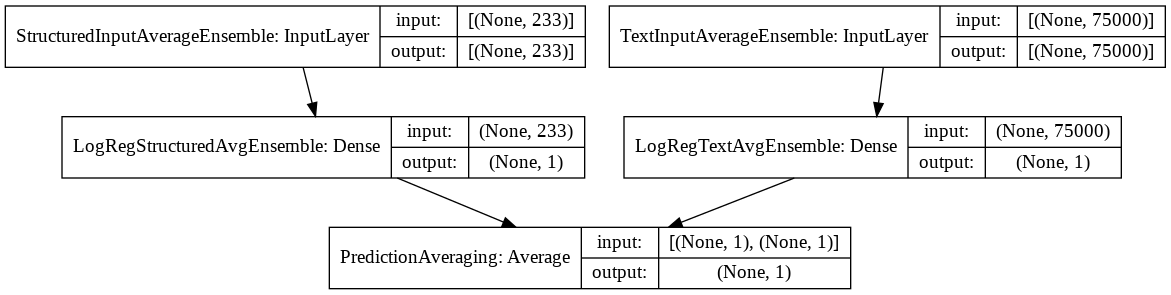

In [ ]:
# Create an average ensemble model
structured_input_avg = Input(shape=(233,), sparse=False, name="StructuredInputAverageEnsemble")
structured_output_avg = Dense(1, activation="sigmoid", kernel_initializer=GlorotNormal(seed=seed_value), name="LogRegStructuredAvgEnsemble")(structured_input_avg)

text_input_avg = Input(shape=(75000,), sparse=True, name="TextInputAverageEnsemble")
text_output_avg = Dense(1, activation="sigmoid", kernel_initializer=GlorotNormal(seed=seed_value), name="LogRegTextAvgEnsemble")(text_input_avg)

output_avg = Average(name="PredictionAveraging")([structured_output_avg, text_output_avg])

average_ensemble_trainable = Model([structured_input_avg, text_input_avg], output_avg, name="AvgEnsembleTrainable")

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
average_ensemble_trainable.summary()

Model: "AvgEnsembleTrainable"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
StructuredInputAverageEnsemble  [(None, 233)]        0                                            
__________________________________________________________________________________________________
TextInputAverageEnsemble (Input [(None, 75000)]      0                                            
__________________________________________________________________________________________________
LogRegStructuredAvgEnsemble (De (None, 1)            234         StructuredInputAverageEnsemble[0]
__________________________________________________________________________________________________
LogRegTextAvgEnsemble (Dense)   (None, 1)            75001       TextInputAverageEnsemble[0][0]   
_______________________________________________________________________________

In [ ]:
# Train and Evaluate Model
average_ensemble_trainable.compile(optimizer=RMSprop(), loss="binary_crossentropy", metrics=["binary_accuracy"])
history = average_ensemble_trainable.fit([X_subtrain_structured, X_subtrain_text], y_subtrain, 
                    validation_data=([X_val_structured, X_val_text], y_val), batch_size=512, epochs=100, verbose=1, 
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_binary_accuracy", patience=5, mode="max", restore_best_weights=True, verbose=0)])
print("Training Accuracy: {:.3f}".format(average_ensemble_trainable.evaluate([X_subtrain_structured, X_subtrain_text], y_subtrain, batch_size=512, verbose=0)[1]))
print("Validation Accuracy: {:.3f}".format(average_ensemble_trainable.evaluate([X_val_structured, X_val_text], y_val, batch_size=512, verbose=0)[1]))

Epoch 1/100
338/338 [==============================] - 8s 22ms/step - loss: 0.4484 - binary_accuracy: 0.7992 - val_loss: 0.4379 - val_binary_accuracy: 0.8015
Epoch 2/100
338/338 [==============================] - 5s 13ms/step - loss: 0.4289 - binary_accuracy: 0.8082 - val_loss: 0.4251 - val_binary_accuracy: 0.8075
Epoch 3/100
338/338 [==============================] - 5s 14ms/step - loss: 0.4142 - binary_accuracy: 0.8143 - val_loss: 0.4164 - val_binary_accuracy: 0.8112
Epoch 4/100
338/338 [==============================] - 5s 14ms/step - loss: 0.4063 - binary_accuracy: 0.8173 - val_loss: 0.4102 - val_binary_accuracy: 0.8139
Epoch 5/100
338/338 [==============================] - 5s 14ms/step - loss: 0.3984 - binary_accuracy: 0.8211 - val_loss: 0.4056 - val_binary_accuracy: 0.8161
Epoch 6/100
338/338 [==============================] - 5s 14ms/step - loss: 0.3917 - binary_accuracy: 0.8242 - val_loss: 0.4021 - val_binary_accuracy: 0.8173
Epoch 7/100
338/338 [==============================]

##### 2. Averaging Ensemble - Frozen Weights

In [ ]:
# Train Best-Found Model On Text Data
text_input_logreg = Input(shape=(75000,), sparse=True, name="TextInputLogReg")
text_logreg_layer = Dense(1, activation="sigmoid", kernel_initializer=GlorotNormal(seed=seed_value), name="TextLogRegLayer")
text_output_logreg = text_logreg_layer(text_input_logreg)
text_logreg = Model(text_input_logreg, text_output_logreg, name="TextLogReg")
text_logreg.compile(optimizer=RMSprop(), loss="binary_crossentropy", metrics=["binary_accuracy"])
history = text_logreg.fit(X_subtrain_text, y_subtrain, validation_data=(X_val_text, y_val), batch_size=512, epochs=29, verbose=1)
print("Training Accuracy: {:.3f}".format(text_logreg.evaluate(X_subtrain_text, y_subtrain, batch_size=512, verbose=0)[1]))
print("Validation Accuracy: {:.3f}".format(text_logreg.evaluate(X_val_text, y_val, batch_size=512, verbose=0)[1]))

Epoch 1/29
338/338 [==============================] - 5s 13ms/step - loss: 0.6361 - binary_accuracy: 0.6567 - val_loss: 0.5635 - val_binary_accuracy: 0.7211
Epoch 2/29
338/338 [==============================] - 4s 10ms/step - loss: 0.5463 - binary_accuracy: 0.7376 - val_loss: 0.5204 - val_binary_accuracy: 0.7524
Epoch 3/29
338/338 [==============================] - 15s 43ms/step - loss: 0.5056 - binary_accuracy: 0.7650 - val_loss: 0.4970 - val_binary_accuracy: 0.7670
Epoch 4/29
338/338 [==============================] - 4s 10ms/step - loss: 0.4835 - binary_accuracy: 0.7775 - val_loss: 0.4825 - val_binary_accuracy: 0.7731
Epoch 5/29
338/338 [==============================] - 4s 10ms/step - loss: 0.4669 - binary_accuracy: 0.7852 - val_loss: 0.4727 - val_binary_accuracy: 0.7775
Epoch 6/29
338/338 [==============================] - 4s 10ms/step - loss: 0.4553 - binary_accuracy: 0.7912 - val_loss: 0.4656 - val_binary_accuracy: 0.7821
Epoch 7/29
338/338 [==============================] - 4s 

In [ ]:
# Train Best-Found Model On Structured Data
structured_input_logreg = Input(shape=(233,), sparse=False, name="StructuredInputLogReg")
structured_logreg_layer = Dense(1, activation="sigmoid", kernel_initializer=GlorotNormal(seed=seed_value), name="StructuredLogRegLayer")
structured_output_logreg = structured_logreg_layer(structured_input_logreg)
structured_logreg = Model(structured_input_logreg, structured_output_logreg)
structured_logreg.compile(optimizer=RMSprop(centered=True), loss="binary_crossentropy", metrics=["binary_accuracy"])
history = structured_logreg.fit(X_subtrain_structured, y_subtrain, validation_data=(X_val_structured, y_val), batch_size=512, epochs=23, verbose=1)
print("Training Accuracy: {:.3f}".format(structured_logreg.evaluate(X_subtrain_structured, y_subtrain, batch_size=512, verbose=0)[1]))
print("Validation Accuracy: {:.3f}".format(structured_logreg.evaluate(X_val_structured, y_val, batch_size=512, verbose=0)[1]))

Epoch 1/23
338/338 [==============================] - 1s 3ms/step - loss: 0.5514 - binary_accuracy: 0.7087 - val_loss: 0.4512 - val_binary_accuracy: 0.7807
Epoch 2/23
338/338 [==============================] - 1s 2ms/step - loss: 0.4441 - binary_accuracy: 0.7828 - val_loss: 0.4377 - val_binary_accuracy: 0.7882
Epoch 3/23
338/338 [==============================] - 1s 3ms/step - loss: 0.4334 - binary_accuracy: 0.7899 - val_loss: 0.4328 - val_binary_accuracy: 0.7909
Epoch 4/23
338/338 [==============================] - 1s 2ms/step - loss: 0.4297 - binary_accuracy: 0.7916 - val_loss: 0.4307 - val_binary_accuracy: 0.7917
Epoch 5/23
338/338 [==============================] - 1s 2ms/step - loss: 0.4276 - binary_accuracy: 0.7928 - val_loss: 0.4293 - val_binary_accuracy: 0.7929
Epoch 6/23
338/338 [==============================] - 11s 31ms/step - loss: 0.4252 - binary_accuracy: 0.7946 - val_loss: 0.4286 - val_binary_accuracy: 0.7928
Epoch 7/23
338/338 [==============================] - 1s 2ms/s

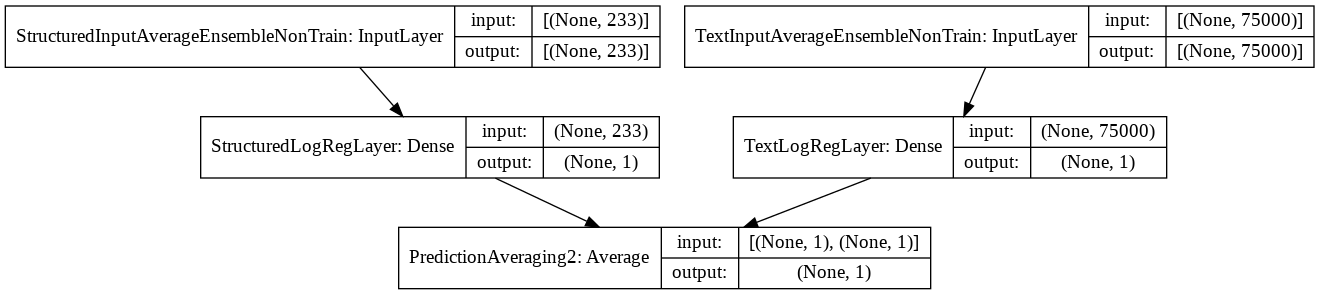

In [ ]:
# Create an average ensemble model
structured_input_avg_nt = Input(shape=(233,), sparse=False, name="StructuredInputAverageEnsembleNonTrain")
structured_output_avg_nt = structured_logreg_layer(structured_input_avg_nt)
structured_logreg_layer.trainable = False

text_input_avg_nt = Input(shape=(75000,), sparse=True, name="TextInputAverageEnsembleNonTrain")
text_output_avg_nt = text_logreg_layer(text_input_avg_nt)
text_logreg_layer.trainable = False

output_avg_nt = Average(name="PredictionAveraging2")([structured_output_avg_nt, text_output_avg_nt])

average_ensemble_non_trainable = Model([structured_input_avg_nt, text_input_avg_nt], output_avg_nt, name="AverageEnsembleNonTrainable")

plot_model(average_ensemble_non_trainable, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
average_ensemble_non_trainable.summary()

Model: "AverageEnsembleNonTrainable"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
StructuredInputAverageEnsembleN [(None, 233)]        0                                            
__________________________________________________________________________________________________
TextInputAverageEnsembleNonTrai [(None, 75000)]      0                                            
__________________________________________________________________________________________________
StructuredLogRegLayer (Dense)   (None, 1)            234         StructuredInputAverageEnsembleNon
__________________________________________________________________________________________________
TextLogRegLayer (Dense)         (None, 1)            75001       TextInputAverageEnsembleNonTrain[
________________________________________________________________________

In [ ]:
# Train and Evaluate Model
average_ensemble_non_trainable.compile(optimizer=RMSprop(), loss="binary_crossentropy", metrics=["binary_accuracy"])
history = average_ensemble_non_trainable.fit([X_subtrain_structured, X_subtrain_text], y_subtrain, 
                    validation_data=([X_val_structured, X_val_text], y_val), batch_size=512, epochs=10, verbose=1, 
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_binary_accuracy", patience=5, mode="max", restore_best_weights=True, verbose=0)])
print("Training Accuracy: {:.3f}".format(average_ensemble_non_trainable.evaluate([X_subtrain_structured, X_subtrain_text], y_subtrain, batch_size=512, verbose=0)[1]))
print("Validation Accuracy: {:.3f}".format(average_ensemble_non_trainable.evaluate([X_val_structured, X_val_text], y_val, batch_size=512, verbose=0)[1]))

Epoch 1/10
338/338 [==============================] - 5s 12ms/step - loss: 0.3642 - binary_accuracy: 0.8442 - val_loss: 0.3987 - val_binary_accuracy: 0.8219
Epoch 2/10
338/338 [==============================] - 4s 11ms/step - loss: 0.3624 - binary_accuracy: 0.8466 - val_loss: 0.3987 - val_binary_accuracy: 0.8219
Epoch 3/10
338/338 [==============================] - 4s 10ms/step - loss: 0.3614 - binary_accuracy: 0.8478 - val_loss: 0.3987 - val_binary_accuracy: 0.8219
Epoch 4/10
338/338 [==============================] - 4s 10ms/step - loss: 0.3637 - binary_accuracy: 0.8460 - val_loss: 0.3987 - val_binary_accuracy: 0.8219
Epoch 5/10
338/338 [==============================] - 4s 11ms/step - loss: 0.3634 - binary_accuracy: 0.8464 - val_loss: 0.3987 - val_binary_accuracy: 0.8219
Epoch 6/10
338/338 [==============================] - 4s 10ms/step - loss: 0.3641 - binary_accuracy: 0.8440 - val_loss: 0.3987 - val_binary_accuracy: 0.8219
Training Accuracy: 0.846
Validation Accuracy: 0.822


##### 3. Stacking Ensemble - Trainable Weights

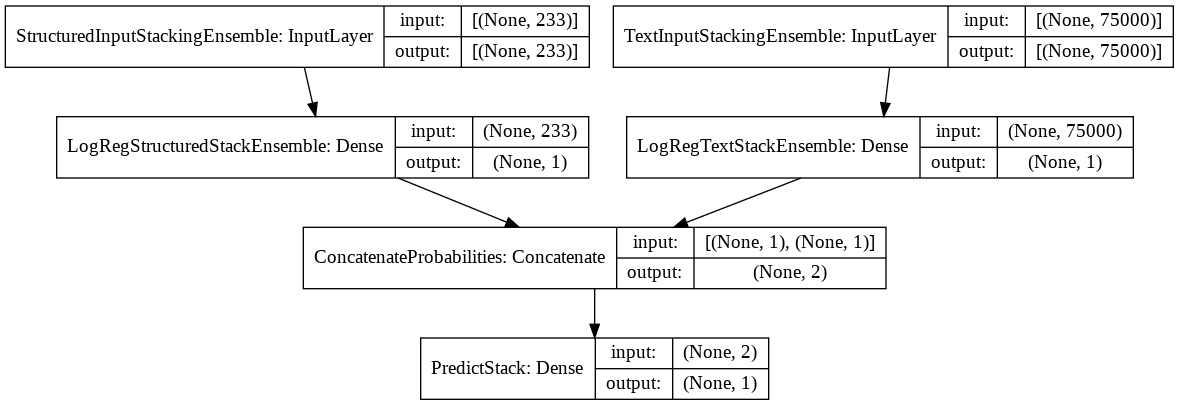

In [ ]:
# Create a stacking ensemble model
structured_input_stack = Input(shape=(233,), sparse=False, name="StructuredInputStackingEnsemble")
structured_output_stack = Dense(1, activation="sigmoid", kernel_initializer=GlorotNormal(seed=seed_value), name="LogRegStructuredStackEnsemble")(structured_input_stack)

text_input_stack = Input(shape=(75000,), sparse=True, name="TextInputStackingEnsemble")
text_output_stack = Dense(1, activation="sigmoid", kernel_initializer=GlorotNormal(seed=seed_value), name="LogRegTextStackEnsemble")(text_input_stack)

concateated_output = Concatenate(name="ConcatenateProbabilities")([structured_output_stack, text_output_stack])

output_stack = Dense(1, activation="sigmoid", kernel_initializer=GlorotNormal(seed=seed_value), name="PredictStack")(concateated_output)

stacking_ensemble_trainable = Model([structured_input_stack, text_input_stack], output_stack, name="StackingEnsembleTrainable")

plot_model(stacking_ensemble_trainable, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
stacking_ensemble_trainable.summary()

Model: "StackingEnsembleTrainable"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
StructuredInputStackingEnsemble [(None, 233)]        0                                            
__________________________________________________________________________________________________
TextInputStackingEnsemble (Inpu [(None, 75000)]      0                                            
__________________________________________________________________________________________________
LogRegStructuredStackEnsemble ( (None, 1)            234         StructuredInputStackingEnsemble[0
__________________________________________________________________________________________________
LogRegTextStackEnsemble (Dense) (None, 1)            75001       TextInputStackingEnsemble[0][0]  
__________________________________________________________________________

In [ ]:
# Train and Evaluate Model
stacking_ensemble_trainable.compile(optimizer=RMSprop(), loss="binary_crossentropy", metrics=["binary_accuracy"])
history = stacking_ensemble_trainable.fit([X_subtrain_structured, X_subtrain_text], y_subtrain, 
                    validation_data=([X_val_structured, X_val_text], y_val), batch_size=512, epochs=100, verbose=1, 
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_binary_accuracy", patience=5, mode="max", restore_best_weights=True, verbose=0)])
print("Training Accuracy: {:.3f}".format(stacking_ensemble_trainable.evaluate([X_subtrain_structured, X_subtrain_text], y_subtrain, batch_size=512, verbose=0)[1]))
print("Validation Accuracy: {:.3f}".format(stacking_ensemble_trainable.evaluate([X_val_structured, X_val_text], y_val, batch_size=512, verbose=0)[1]))

Epoch 1/100
338/338 [==============================] - 6s 14ms/step - loss: 0.6275 - binary_accuracy: 0.6498 - val_loss: 0.5558 - val_binary_accuracy: 0.6690
Epoch 2/100
338/338 [==============================] - 5s 13ms/step - loss: 0.5415 - binary_accuracy: 0.6936 - val_loss: 0.5043 - val_binary_accuracy: 0.7558
Epoch 3/100
338/338 [==============================] - 5s 13ms/step - loss: 0.4923 - binary_accuracy: 0.7687 - val_loss: 0.4683 - val_binary_accuracy: 0.7893
Epoch 4/100
338/338 [==============================] - 4s 12ms/step - loss: 0.4572 - binary_accuracy: 0.7958 - val_loss: 0.4426 - val_binary_accuracy: 0.8018
Epoch 5/100
338/338 [==============================] - 4s 12ms/step - loss: 0.4317 - binary_accuracy: 0.8092 - val_loss: 0.4242 - val_binary_accuracy: 0.8090
Epoch 6/100
338/338 [==============================] - 14s 41ms/step - loss: 0.4140 - binary_accuracy: 0.8159 - val_loss: 0.4110 - val_binary_accuracy: 0.8134
Epoch 7/100
338/338 [==============================

##### 4. Stacking Ensemble - Frozen Weights

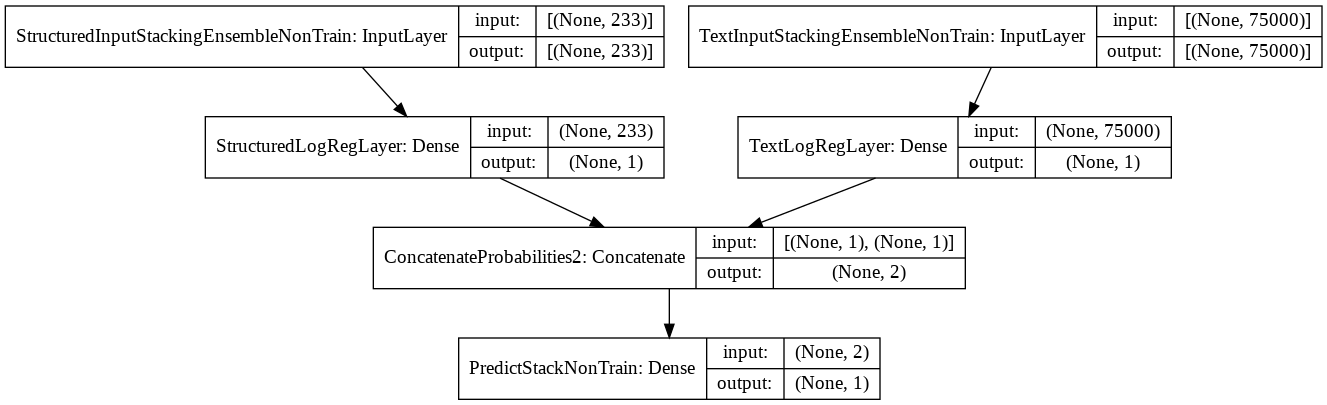

In [ ]:
# Create a stacking ensemble model
structured_input_stack_nt = Input(shape=(233,), sparse=False, name="StructuredInputStackingEnsembleNonTrain")
structured_output_stack_nt = structured_logreg_layer(structured_input_stack_nt)
structured_logreg_layer.trainable=False

text_input_stack_nt = Input(shape=(75000,), sparse=True, name="TextInputStackingEnsembleNonTrain")
text_output_stack_nt = text_logreg_layer(text_input_stack_nt)
text_logreg_layer.trainable=False

concateated_output_nt = Concatenate(name="ConcatenateProbabilities2")([structured_output_stack_nt, text_output_stack_nt])

output_stack_nt = Dense(1, activation="sigmoid", kernel_initializer=GlorotNormal(seed=seed_value), name="PredictStackNonTrain")(concateated_output_nt)

stacking_ensemble_non_trainable = Model([structured_input_stack_nt, text_input_stack_nt], output_stack_nt, name="StackingEnsembleNonTrainable")

plot_model(stacking_ensemble_non_trainable, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
stacking_ensemble_non_trainable.summary()

Model: "StackingEnsembleNonTrainable"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
StructuredInputStackingEnsemble [(None, 233)]        0                                            
__________________________________________________________________________________________________
TextInputStackingEnsembleNonTra [(None, 75000)]      0                                            
__________________________________________________________________________________________________
StructuredLogRegLayer (Dense)   (None, 1)            234         StructuredInputStackingEnsembleNo
__________________________________________________________________________________________________
TextLogRegLayer (Dense)         (None, 1)            75001       TextInputStackingEnsembleNonTrain
_______________________________________________________________________

In [ ]:
# Train and Evaluate Model
stacking_ensemble_non_trainable.compile(optimizer=RMSprop(), loss="binary_crossentropy", metrics=["binary_accuracy"])
history = stacking_ensemble_non_trainable.fit([X_subtrain_structured, X_subtrain_text], y_subtrain, 
                    validation_data=([X_val_structured, X_val_text], y_val), batch_size=512, epochs=100, verbose=1, 
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_binary_accuracy", patience=5, mode="max", restore_best_weights=True, verbose=0)])
print("Training Accuracy: {:.3f}".format(stacking_ensemble_non_trainable.evaluate([X_subtrain_structured, X_subtrain_text], y_subtrain, batch_size=512, verbose=0)[1]))
print("Validation Accuracy: {:.3f}".format(stacking_ensemble_non_trainable.evaluate([X_val_structured, X_val_text], y_val, batch_size=512, verbose=0)[1]))

Epoch 1/100
338/338 [==============================] - 5s 13ms/step - loss: 0.8460 - binary_accuracy: 0.6518 - val_loss: 0.7839 - val_binary_accuracy: 0.6501
Epoch 2/100
338/338 [==============================] - 4s 11ms/step - loss: 0.7678 - binary_accuracy: 0.6500 - val_loss: 0.7146 - val_binary_accuracy: 0.6501
Epoch 3/100
338/338 [==============================] - 4s 11ms/step - loss: 0.6931 - binary_accuracy: 0.6516 - val_loss: 0.6522 - val_binary_accuracy: 0.6501
Epoch 4/100
338/338 [==============================] - 4s 11ms/step - loss: 0.6280 - binary_accuracy: 0.6505 - val_loss: 0.5975 - val_binary_accuracy: 0.6515
Epoch 5/100
338/338 [==============================] - 4s 11ms/step - loss: 0.5694 - binary_accuracy: 0.6781 - val_loss: 0.5505 - val_binary_accuracy: 0.7470
Epoch 6/100
338/338 [==============================] - 4s 11ms/step - loss: 0.5197 - binary_accuracy: 0.7876 - val_loss: 0.5110 - val_binary_accuracy: 0.7864
Epoch 7/100
338/338 [==============================]

#### b) Single Logistic Regression with Merged Dataset

##### Baseline:

In [ ]:
# Take as baseline the best model that was found by the text-only LR
model = Sequential()
model.add(Input(shape=(X_train.shape[1],), sparse=True, batch_size=512))
model.add(Dense(1, activation="sigmoid", kernel_initializer=GlorotNormal(seed=seed_value)))
model.compile(optimizer=RMSprop(), loss="binary_crossentropy", metrics=["binary_accuracy"])
history = model.fit(X_subtrain, y_subtrain, validation_data=(X_val, y_val), batch_size=512, epochs=100, verbose=1, callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_binary_accuracy", patience=5, mode="max", restore_best_weights=True, verbose=0)])
print("Training Accuracy: {:.3f}".format(model.evaluate(X_subtrain, y_subtrain, batch_size=512, verbose=0)[1]))
print("Validation Accuracy: {:.3f}".format(model.evaluate(X_val, y_val, batch_size=512, verbose=0)[1]))

Epoch 1/100
338/338 [==============================] - 5s 11ms/step - loss: 0.5675 - binary_accuracy: 0.7044 - val_loss: 0.4510 - val_binary_accuracy: 0.7894
Epoch 2/100
338/338 [==============================] - 3s 9ms/step - loss: 0.4348 - binary_accuracy: 0.7999 - val_loss: 0.4130 - val_binary_accuracy: 0.8075
Epoch 3/100
338/338 [==============================] - 3s 9ms/step - loss: 0.3991 - binary_accuracy: 0.8152 - val_loss: 0.3973 - val_binary_accuracy: 0.8147
Epoch 4/100
338/338 [==============================] - 3s 10ms/step - loss: 0.3850 - binary_accuracy: 0.8213 - val_loss: 0.3892 - val_binary_accuracy: 0.8196
Epoch 5/100
338/338 [==============================] - 4s 10ms/step - loss: 0.3737 - binary_accuracy: 0.8265 - val_loss: 0.3844 - val_binary_accuracy: 0.8217
Epoch 6/100
338/338 [==============================] - 14s 40ms/step - loss: 0.3670 - binary_accuracy: 0.8309 - val_loss: 0.3807 - val_binary_accuracy: 0.8232
Epoch 7/100
338/338 [==============================] 

##### Fine-Tune Logistic Regression:

In [ ]:
# Fine-Tune Different Regularizers
counter=0
for regularizer, reg_rate in itertools.product(["L1", "L2"],[0.0001, 0.001, 0.01, 0.1, 1]):
  counter += 1
  print("Round: {}, Params: {} {}".format(counter, regularizer, reg_rate))
  if regularizer=="L1": reg = L1(l1=reg_rate)
  if regularizer=="L2": reg = L2(l2=reg_rate)
  model = Sequential()
  model.add(Input(shape=(X_subtrain.shape[1],), sparse=True, batch_size=512))
  model.add(Dense(1, activation="sigmoid", kernel_regularizer=reg, kernel_initializer=GlorotNormal(seed=seed_value)))
  model.compile(optimizer=RMSprop(), loss="binary_crossentropy", metrics=["binary_accuracy"])
  history = model.fit(X_subtrain, y_subtrain, validation_data=(X_val, y_val), batch_size=512, epochs=100, verbose=1, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=5, verbose=0, mode='max', restore_best_weights=True)])
  print("Training Accuracy: {:.3f}".format(model.evaluate(X_subtrain, y_subtrain, batch_size=512, verbose=0)[1]))
  print("Validation Accuracy: {:.3f}".format(model.evaluate(X_val, y_val, batch_size=512, verbose=0)[1]))

Round: 1, Params: L1 0.0001
Epoch 1/100
338/338 [==============================] - 4s 10ms/step - loss: 0.5928 - binary_accuracy: 0.6956 - val_loss: 0.4932 - val_binary_accuracy: 0.7718
Epoch 2/100
338/338 [==============================] - 3s 9ms/step - loss: 0.4807 - binary_accuracy: 0.7778 - val_loss: 0.4586 - val_binary_accuracy: 0.7870
Epoch 3/100
338/338 [==============================] - 3s 9ms/step - loss: 0.4518 - binary_accuracy: 0.7922 - val_loss: 0.4458 - val_binary_accuracy: 0.7936
Epoch 4/100
338/338 [==============================] - 3s 9ms/step - loss: 0.4398 - binary_accuracy: 0.7975 - val_loss: 0.4407 - val_binary_accuracy: 0.7955
Epoch 5/100
338/338 [==============================] - 3s 9ms/step - loss: 0.4376 - binary_accuracy: 0.7973 - val_loss: 0.4388 - val_binary_accuracy: 0.7969
Epoch 6/100
338/338 [==============================] - 3s 9ms/step - loss: 0.4348 - binary_accuracy: 0.7987 - val_loss: 0.4376 - val_binary_accuracy: 0.7975
Epoch 7/100
338/338 [========

Result: rather don't apply regularization; L2 performed a little bit better than L1

In [ ]:
# Tune different optimizers
counter=0
for optimizer in ["RMSprop", "RMSprop_centered", "Adam", "Adam_amsgrad", "Adamax", "Nadam"]:
  counter += 1
  print("Round: {}, Params: {}".format(counter, optimizer))
  if optimizer=="RMSprop": opt = RMSprop()
  if optimizer=="RMSprop_centered": opt = RMSprop(centered=True)
  if optimizer=="Adam": opt = Adam()
  if optimizer=="Adam_amsgrad": opt = Adam(amsgrad=True)
  if optimizer=="Adamax": opt = Adamax()
  if optimizer=="Nadam": opt = Nadam()
  model = Sequential()
  model.add(Input(shape=(X_subtrain.shape[1],), sparse=True, batch_size=512))
  model.add(Dense(1, activation="sigmoid", kernel_initializer=GlorotNormal(seed=seed_value)))
  model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["binary_accuracy"])
  history = model.fit(X_subtrain, y_subtrain, validation_data=(X_val, y_val), batch_size=512, epochs=100, verbose=1, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=5, verbose=0, mode='max', restore_best_weights=True)])
  print("Training Accuracy: {:.3f}".format(model.evaluate(X_subtrain, y_subtrain, batch_size=512, verbose=0)[1]))
  print("Validation Accuracy: {:.3f}".format(model.evaluate(X_val, y_val, batch_size=512, verbose=0)[1]))

Round: 1, Params: RMSprop
Epoch 1/100
338/338 [==============================] - 14s 40ms/step - loss: 0.5678 - binary_accuracy: 0.7028 - val_loss: 0.4509 - val_binary_accuracy: 0.7900
Epoch 2/100
338/338 [==============================] - 4s 10ms/step - loss: 0.4360 - binary_accuracy: 0.7969 - val_loss: 0.4132 - val_binary_accuracy: 0.8083
Epoch 3/100
338/338 [==============================] - 3s 10ms/step - loss: 0.3995 - binary_accuracy: 0.8161 - val_loss: 0.3974 - val_binary_accuracy: 0.8157
Epoch 4/100
338/338 [==============================] - 4s 10ms/step - loss: 0.3831 - binary_accuracy: 0.8235 - val_loss: 0.3896 - val_binary_accuracy: 0.8194
Epoch 5/100
338/338 [==============================] - 3s 10ms/step - loss: 0.3741 - binary_accuracy: 0.8265 - val_loss: 0.3842 - val_binary_accuracy: 0.8224
Epoch 6/100
338/338 [==============================] - 3s 10ms/step - loss: 0.3690 - binary_accuracy: 0.8303 - val_loss: 0.3806 - val_binary_accuracy: 0.8241
Epoch 7/100
338/338 [====

Result: Adam_amsgrad had the best result with the lowest overfitting, however the differences were marginal

In [ ]:
# Fine-Tune different weight initializers
counter=0
for initializer in ["glorot_normal", "glorot_uniform", "he_normal", "he_uniform", "lecun_normal", "lecun_uniform"]:
  counter += 1
  print("Round: {}, Params: {}".format(counter, initializer))
  if initializer=="glorot_normal": init = GlorotNormal(seed=seed_value)
  if initializer=="glorot_uniform": init = GlorotUniform(seed=seed_value)
  if initializer=="he_normal": init = HeNormal(seed=seed_value)
  if initializer=="he_uniform": init = HeUniform(seed=seed_value)
  if initializer=="lecun_normal": init = LecunNormal(seed=seed_value)
  if initializer=="lecun_uniform": init = LecunUniform(seed=seed_value)
  model = Sequential()
  model.add(Input(shape=(X_subtrain.shape[1],), sparse=True, batch_size=512))
  model.add(Dense(1, activation="sigmoid", kernel_initializer=init))
  model.compile(optimizer=Adam(amsgrad=True), loss="binary_crossentropy", metrics=["binary_accuracy"])
  history = model.fit(X_subtrain, y_subtrain, validation_data=(X_val, y_val), batch_size=512, epochs=100, verbose=1, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=5, verbose=0, mode='max', restore_best_weights=True)])
  print("Training Accuracy: {:.3f}".format(model.evaluate(X_subtrain, y_subtrain, batch_size=512, verbose=0)[1]))
  print("Validation Accuracy: {:.3f}".format(model.evaluate(X_val, y_val, batch_size=512, verbose=0)[1]))

Round: 1, Params: glorot_normal
Epoch 1/100
338/338 [==============================] - 15s 11ms/step - loss: 0.5789 - binary_accuracy: 0.6981 - val_loss: 0.4630 - val_binary_accuracy: 0.7870
Epoch 2/100
338/338 [==============================] - 3s 10ms/step - loss: 0.4472 - binary_accuracy: 0.7935 - val_loss: 0.4242 - val_binary_accuracy: 0.8040
Epoch 3/100
338/338 [==============================] - 4s 10ms/step - loss: 0.4120 - binary_accuracy: 0.8124 - val_loss: 0.4061 - val_binary_accuracy: 0.8129
Epoch 4/100
338/338 [==============================] - 3s 10ms/step - loss: 0.3927 - binary_accuracy: 0.8206 - val_loss: 0.3956 - val_binary_accuracy: 0.8176
Epoch 5/100
338/338 [==============================] - 4s 10ms/step - loss: 0.3797 - binary_accuracy: 0.8272 - val_loss: 0.3889 - val_binary_accuracy: 0.8209
Epoch 6/100
338/338 [==============================] - 3s 10ms/step - loss: 0.3711 - binary_accuracy: 0.8309 - val_loss: 0.3839 - val_binary_accuracy: 0.8231
Epoch 7/100
338/338

Results: glorot uniform led to the least overfitting, but validation accuracies were almost the same across all initializers

In [ ]:
# Fine-Tune Different Batch Sizes
counter=0
for batch_size in [16, 32, 64, 128, 256, 512, 1024]:
  counter += 1
  print("Round: {}, Params: {}".format(counter, batch_size))
  model = Sequential()
  model.add(Input(shape=(X_subtrain.shape[1],), sparse=True, batch_size=batch_size))
  model.add(Dense(1, activation="sigmoid", kernel_initializer=GlorotUniform(seed=seed_value)))
  model.compile(optimizer=Adam(amsgrad=True), loss="binary_crossentropy", metrics=["binary_accuracy"])
  history = model.fit(X_subtrain, y_subtrain, validation_data=(X_val, y_val), batch_size=batch_size, epochs=100, verbose=1, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=5, verbose=0, mode='max', restore_best_weights=True)])
  print("Training Accuracy: {:.3f}".format(model.evaluate(X_subtrain, y_subtrain, batch_size=batch_size, verbose=0)[1]))
  print("Validation Accuracy: {:.3f}".format(model.evaluate(X_val, y_val, batch_size=batch_size, verbose=0)[1]))

Round: 1, Params: 16
Epoch 1/100
10802/10802 [==============================] - 38s 3ms/step - loss: 0.4468 - binary_accuracy: 0.7836 - val_loss: 0.3832 - val_binary_accuracy: 0.8219
Epoch 2/100
10802/10802 [==============================] - 28s 3ms/step - loss: 0.3626 - binary_accuracy: 0.8325 - val_loss: 0.3733 - val_binary_accuracy: 0.8268
Epoch 3/100
10802/10802 [==============================] - 28s 3ms/step - loss: 0.3434 - binary_accuracy: 0.8446 - val_loss: 0.3683 - val_binary_accuracy: 0.8303
Epoch 4/100
10802/10802 [==============================] - 29s 3ms/step - loss: 0.3314 - binary_accuracy: 0.8514 - val_loss: 0.3664 - val_binary_accuracy: 0.8296
Epoch 5/100
10802/10802 [==============================] - 29s 3ms/step - loss: 0.3192 - binary_accuracy: 0.8588 - val_loss: 0.3658 - val_binary_accuracy: 0.8309
Epoch 6/100
10802/10802 [==============================] - 30s 3ms/step - loss: 0.3080 - binary_accuracy: 0.8661 - val_loss: 0.3660 - val_binary_accuracy: 0.8308
Epoch 7

Result: batch size of 512 works best

#### Best-Found Model: LR Structured + Text

- single LR with merged dataset
- Output Activation = sigmoid (necessary to retrieve probability between 0 and 1)
- No regularization
- AMSGrad optimizer
- GlorotUniform initialization
- Batch Size: 512